# Episode 4: LangGraph Concepts Deep Dive

Welcome! In this notebook, we'll explore the **core concepts** of LangGraph in depth:

1. **Graphs** - How LangGraph executes workflows
2. **State** - Managing data flow through your graph
3. **Nodes** - The workers that do the actual work
4. **Edges** - Controlling the flow between nodes

By the end, you'll have a solid mental model of how LangGraph works under the hood!

## Setup

First, let's import what we need:

In [ ]:
from typing import Annotated, Literal
from typing_extensions import TypedDict
from operator import add

from dotenv import load_dotenv
from langchain_core.messages import HumanMessage, AIMessage, AnyMessage
from langchain_core.runnables import RunnableConfig

from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

# Load environment variables
load_dotenv()

print("✓ Setup complete!")

✓ Setup complete!


---

# Part 1: Understanding Graphs

## What is a Graph?

At its core, LangGraph models agent workflows as **graphs**. Think of it like a flowchart where:
- **Nodes** are the boxes (functions that do work)
- **Edges** are the arrows (connections between nodes)
- **State** is the data flowing through the system

```
    START
      ↓
    Node A
      ↓
    Node B
      ↓
     END
```

## How Graphs Execute: Super-Steps

LangGraph uses **message passing** inspired by Google's Pregel system. Execution happens in discrete "super-steps":

- **Super-step**: One iteration over the graph nodes
- **Parallel nodes**: Run in the same super-step
- **Sequential nodes**: Run in separate super-steps

Let's see this in action:

In [51]:
# Simple state for demonstration
class SimpleState(TypedDict):
    value: int

# Define nodes that print when they execute
def node_a(state: SimpleState) -> SimpleState:
    print("  Executing Node A")
    return {"value": state["value"] + 1}

def node_b(state: SimpleState) -> SimpleState:
    print("  Executing Node B")
    return {"value": state["value"] * 2}

def node_c(state: SimpleState) -> SimpleState:
    print("  Executing Node C")
    return {"value": state["value"] + 10}

# Build a simple sequential graph
graph = StateGraph(SimpleState)
graph.add_node("a", node_a)
graph.add_node("b", node_b)
graph.add_node("c", node_c)

# Sequential flow: A → B → C
graph.add_edge(START, "a")
graph.add_edge("a", "b")
graph.add_edge("b", "c")
graph.add_edge("c", END)

app = graph.compile()

# Run it
print("Sequential Execution:")
result = app.invoke({"value": 5})
print(f"\nFinal value: {result['value']}")
print("Calculation: (5 + 1) * 2 + 10 = 22")

Sequential Execution:
  Executing Node A
  Executing Node B
  Executing Node C

Final value: 22
Calculation: (5 + 1) * 2 + 10 = 22


### Visualize the Graph

Let's see what this graph looks like:

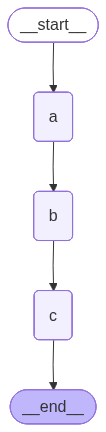

In [52]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    print(app.get_graph().draw_ascii())

### Parallel Execution

Now let's see parallel execution. If multiple edges point to different nodes from the same source, they run in parallel:

In [57]:
# Build a graph with parallel execution
class SimpleState(TypedDict):
    value: Annotated[int, add]

parallel_graph = StateGraph(SimpleState)
parallel_graph.add_node("start_node", node_a) # increment by 1
parallel_graph.add_node("parallel_1", node_b) # double
parallel_graph.add_node("parallel_2", node_c) # add 10

# Start node, then TWO nodes in parallel
parallel_graph.add_edge(START, "start_node")
parallel_graph.add_edge("start_node", "parallel_1")  # Both run in parallel!
parallel_graph.add_edge("start_node", "parallel_2")  # Same super-step
parallel_graph.add_edge("parallel_1", END)
parallel_graph.add_edge("parallel_2", END)

parallel_app = parallel_graph.compile()

print("Parallel Execution:")
result = parallel_app.invoke({"value": 5})
print(f"\nFinal value: {result['value']}")
print("Note: Parallel nodes executed in the same super-step!")

Parallel Execution:
  Executing Node A
  Executing Node C
  Executing Node B

Final value: 54
Note: Parallel nodes executed in the same super-step!


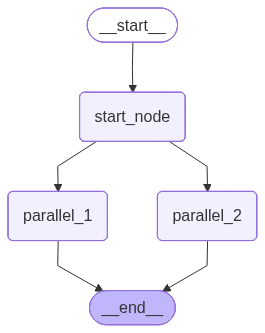

In [ ]:
from IPython.display import Image, display

try:
    display(Image(parallel_app.get_graph().draw_mermaid_png()))
except Exception:
    print(parallel_app.get_graph().draw_ascii())

**Key Takeaway**: Nodes connected from the same source run **in parallel** (same super-step). Nodes in sequence run in **separate super-steps**.

---

# Part 2: State - The Backbone of LangGraph

## What is State?

State is the **shared data structure** that flows through your graph. It consists of:
1. **Schema** - The structure of your data (TypedDict, Pydantic, dataclass)
2. **Reducers** - Functions that control how updates are applied

## State Schema

You can define state using different approaches:

In [ ]:
# Approach 1: TypedDict (most common)
class MyState(TypedDict):
    count: int
    messages: list[str]
    user_name: str

# Approach 2: TypedDict with defaults using dataclass
from dataclasses import dataclass, field

@dataclass
class MyStateWithDefaults:
    count: int = 0
    messages: list[str] = field(default_factory=list)
    user_name: str = "Anonymous"

# Approach 3: Pydantic (for validation)
from pydantic import BaseModel, Field

class MyPydanticState(BaseModel):
    count: int = Field(default=0, ge=0)  # Must be >= 0
    messages: list[str] = Field(default_factory=list)
    user_name: str = "Anonymous"

print("✓ Three ways to define state schemas")

✓ Three ways to define state schemas


## Reducers: How State Updates Work

**Reducers** control how updates are applied to each state key. By default, updates **overwrite** the previous value.

### Default Reducer (Overwrite)

In [ ]:
class StateWithOverwrite(TypedDict):
    counter: int
    message: str

def node_1(state: StateWithOverwrite) -> StateWithOverwrite:
    print(f"Node 1 - Current state: {state}")
    return {"counter": 10, "message": "Hello"}  # Overwrites

def node_2(state: StateWithOverwrite) -> StateWithOverwrite:
    print(f"Node 2 - Current state: {state}")
    return {"counter": 20}  # Only updates counter, message stays

# Build graph
overwrite_graph = StateGraph(StateWithOverwrite)
overwrite_graph.add_node("n1", node_1)
overwrite_graph.add_node("n2", node_2)
overwrite_graph.add_edge(START, "n1")
overwrite_graph.add_edge("n1", "n2")
overwrite_graph.add_edge("n2", END)

# START --> n1 --> n2 --> END

overwrite_app = overwrite_graph.compile()

print("\n=== Default Reducer (Overwrite) ===")
result = overwrite_app.invoke({"counter": 0, "message": "Start"})
print(f"\nFinal state: {result}")


=== Default Reducer (Overwrite) ===
Node 1 - Current state: {'counter': 0, 'message': 'Start'}
Node 2 - Current state: {'counter': 10, 'message': 'Hello'}

Final state: {'counter': 20, 'message': 'Hello'}


### Custom Reducer (Addition)

Use `Annotated[type, reducer_function]` to specify a custom reducer:

In [ ]:
from operator import add

class StateWithAddition(TypedDict):
    counter: Annotated[int, add]  # Use addition reducer
    items: Annotated[list[str], add]  # Concatenate lists

def increment_node(state: StateWithAddition) -> StateWithAddition:
    print(f"Increment - Current state: {state}")
    return {"counter": 5, "items": ["apple"]}

def add_more_node(state: StateWithAddition) -> StateWithAddition:
    print(f"Add More - Current state: {state}")
    return {"counter": 3, "items": ["banana", "cherry"]}

# Build graph
add_graph = StateGraph(StateWithAddition)
add_graph.add_node("increment", increment_node)
add_graph.add_node("add_more", add_more_node)
add_graph.add_edge(START, "increment")
add_graph.add_edge("increment", "add_more")
add_graph.add_edge("add_more", END)

# START --> increment --> add_more--> END

add_app = add_graph.compile()

print("\n=== Addition Reducer ===")
result = add_app.invoke({"counter": 10, "items": ["orange"]})
print(f"\nFinal state: {result}")
print("Counter: 10 + 5 + 3 = 18")
print("Items: ['orange'] + ['apple'] + ['banana', 'cherry']")


=== Addition Reducer ===
Increment - Current state: {'counter': 10, 'items': ['orange']}
Add More - Current state: {'counter': 15, 'items': ['orange', 'apple']}

Final state: {'counter': 18, 'items': ['orange', 'apple', 'banana', 'cherry']}
Counter: 10 + 5 + 3 = 18
Items: ['orange'] + ['apple'] + ['banana', 'cherry']


### The Special `add_messages` Reducer

For conversation history, LangGraph provides `add_messages` - it's smart about message IDs and updates:

In [ ]:
class ConversationState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

def user_node(state: ConversationState) -> ConversationState:
    return {"messages": [HumanMessage(content="Hello!")]}

def ai_node(state: ConversationState) -> ConversationState:
    return {"messages": [AIMessage(content="Hi there! How can I help?")]}

# Build conversation graph
conv_graph = StateGraph(ConversationState)
conv_graph.add_node("user", user_node)
conv_graph.add_node("ai", ai_node)
conv_graph.add_edge(START, "user")
conv_graph.add_edge("user", "ai")
conv_graph.add_edge("ai", END)

conv_app = conv_graph.compile()

# START --> user --> ai --> END

print("\n=== add_messages Reducer ===")
result = conv_app.invoke({"messages": []})
print(f"\nMessages in state:")
for msg in result["messages"]:
    print(f"  {type(msg).__name__}: {msg.content}")


=== add_messages Reducer ===

Messages in state:
  HumanMessage: Hello!
  AIMessage: Hi there! How can I help?


### MessagesState Helper

Since conversation state is so common, LangGraph provides `MessagesState`:

In [21]:
# Instead of defining this every time:
# class MyState(TypedDict):
#     messages: Annotated[list[AnyMessage], add_messages]
#     other_field: str

# You can do this:
class MyState(MessagesState):
    other_field: str  # Add your own fields
    user_id: int

print("✓ MessagesState automatically includes 'messages' field with add_messages reducer")

✓ MessagesState automatically includes 'messages' field with add_messages reducer


## Multiple State Schemas

You can have:
- **Input Schema**: What the graph accepts
- **Output Schema**: What the graph returns
- **Internal Schema**: Full state used internally
- **Private Schemas**: For node-to-node communication

In [ ]:
# Define different schemas
class InputSchema(TypedDict):
    user_input: str

class OutputSchema(TypedDict):
    result: str

class InternalSchema(TypedDict):
    user_input: str
    result: str
    intermediate_data: str  # Only used internally

def process_input(state: InputSchema) -> InternalSchema:
    return {
        "intermediate_data": state["user_input"].upper(),
        "result": ""
    }

def generate_output(state: InternalSchema) -> OutputSchema:
    return {"result": f"Processed: {state['intermediate_data']}"}

# Build graph with input/output schemas
multi_schema_graph = StateGraph(
    InternalSchema,
    input_schema=InputSchema,
    output_schema=OutputSchema
)
multi_schema_graph.add_node("process", process_input)
multi_schema_graph.add_node("output", generate_output)
multi_schema_graph.add_edge(START, "process")
multi_schema_graph.add_edge("process", "output")
multi_schema_graph.add_edge("output", END)

# START --> process --> output --> END

multi_schema_app = multi_schema_graph.compile()

print("\n=== Multiple Schemas ===")
result = multi_schema_app.invoke({"user_input": "hello world"})
print(f"Output: {result}")
print("Note: intermediate_data is not in the output!")


=== Multiple Schemas ===
Output: {'result': 'Processed: HELLO WORLD'}
Note: intermediate_data is not in the output!


---

# Part 3: Nodes - The Workers

## What are Nodes?

Nodes are **just Python functions** that:
1. Accept the current state
2. Optionally accept `config` and `runtime` parameters
3. Return state updates

## Node Signatures

In [ ]:
from langgraph.runtime import Runtime
from dataclasses import dataclass

@dataclass
class Context:
    user_id: str
    api_key: str

class NodeExampleState(TypedDict):
    value: int

# Basic node - just state
def basic_node(state: NodeExampleState) -> NodeExampleState:
    print("Basic node executing")
    return {"value": state["value"] + 1}

# Node with config - access thread_id, tags, etc.
def node_with_config(state: NodeExampleState, config: RunnableConfig) -> NodeExampleState:
    thread_id = config.get("configurable", {}).get("thread_id", "unknown")
    print(f"Node executing in thread: {thread_id}")
    return {"value": state["value"] * 2}

# Node with runtime - access context
def node_with_runtime(state: NodeExampleState, runtime: Runtime[Context]) -> NodeExampleState:
    print(f"Node executing for user: {runtime.context.user_id}")
    return {"value": state["value"] + 10}

print("✓ Three node signature examples defined")

✓ Three node signature examples defined


## Special Nodes: START and END

In [ ]:
from langgraph.graph import START, END

# START: Virtual node representing the entry point
# END: Virtual node representing termination

example_graph = StateGraph(NodeExampleState)
example_graph.add_node("work", basic_node)

# START determines which nodes run first
example_graph.add_edge(START, "work")

# END determines when execution stops
example_graph.add_edge("work", END)

# START --> work --> END

example_app = example_graph.compile()

print("\n=== START and END ===")
result = example_app.invoke({"value": 5})
print(f"Result: {result}")


=== START and END ===
Basic node executing
Result: {'value': 6}


## Async Nodes

Nodes can be async for I/O-bound operations:

In [ ]:
import asyncio

async def async_node(state: NodeExampleState) -> NodeExampleState:
    print("Async node starting...")
    await asyncio.sleep(0.1)  # Simulate async operation
    print("Async node completed")
    return {"value": state["value"] * 3}

async_graph = StateGraph(NodeExampleState)
async_graph.add_node("async_work", async_node)
async_graph.add_edge(START, "async_work")
async_graph.add_edge("async_work", END)

# START --> async_work --> END

async_app = async_graph.compile()

print("\n=== Async Node ===")
result = await async_app.ainvoke({"value": 5})
print(f"Result: {result}")


=== Async Node ===
Async node starting...
Async node completed
Result: {'value': 15}


---

# Part 4: Edges - Controlling Flow

## Types of Edges

1. **Normal Edges**: Always go from A → B
2. **Conditional Edges**: Decide dynamically where to go
3. **Entry Points**: Where to start
4. **Conditional Entry Points**: Dynamic starting points

## Normal Edges

In [37]:
class EdgeState(TypedDict):
    value: str

def step_1(state: EdgeState) -> EdgeState:
    print("Step 1")
    return {"value": state["value"] + " -> Step1"}

def step_2(state: EdgeState) -> EdgeState:
    print("Step 2")
    return {"value": state["value"] + " -> Step2"}

normal_edge_graph = StateGraph(EdgeState)
normal_edge_graph.add_node("s1", step_1)
normal_edge_graph.add_node("s2", step_2)

# Normal edges: always follow this path
normal_edge_graph.add_edge(START, "s1")
normal_edge_graph.add_edge("s1", "s2")  # s1 ALWAYS goes to s2
normal_edge_graph.add_edge("s2", END)

# START --> s1 --> s2 --> END

normal_app = normal_edge_graph.compile()

print("\n=== Normal Edges ===")
result = normal_app.invoke({"value": "Start"})
print(f"Path: {result['value']}")


=== Normal Edges ===
Step 1
Step 2
Path: Start -> Step1 -> Step2


## Command: Combining State Updates + Routing

`Command` lets you update state AND route in a single node:

In [ ]:
from langgraph.types import Command

class CommandState(TypedDict):
    counter: int
    should_continue: bool

def increment_and_route(state: CommandState) -> Command[Literal["increment_and_route", "finish"]]:
    new_counter = state["counter"] + 1
    print(f"Counter: {new_counter}")
    
    if new_counter < 3:
        # Update state AND route back to self (loop)
        return Command(
            update={"counter": new_counter},
            goto="increment_and_route"
        )
    else:
        # Update state AND route to finish
        return Command(
            update={"counter": new_counter, "should_continue": False},
            goto="finish"
        )

def finish(state: CommandState) -> CommandState:
    print("Finished!")
    return state

command_graph = StateGraph(CommandState)
command_graph.add_node("increment_and_route", increment_and_route)
command_graph.add_node("finish", finish)
command_graph.add_edge(START, "increment_and_route")
command_graph.add_edge("finish", END)

command_app = command_graph.compile()

print("\n=== Command (State Update + Routing) ===")
result = command_app.invoke({"counter": 0, "should_continue": True})
print(f"\nFinal state: {result}")


=== Command (State Update + Routing) ===
Counter: 1
Counter: 2
Counter: 3
Finished!

Final state: {'counter': 3, 'should_continue': False}


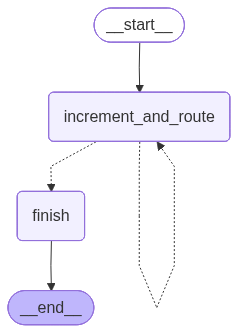

In [38]:
from IPython.display import Image, display

try:
    display(Image(command_app.get_graph().draw_mermaid_png()))
except Exception:
    print(command_app.get_graph().draw_ascii())

---

# Part 5: Putting It All Together

Let's build a practical example that uses all these concepts:

In [39]:
# A simple chatbot that categorizes questions and responds
from langchain_core.messages import SystemMessage

class ChatbotState(MessagesState):
    category: str  # "greeting", "question", or "goodbye"

def categorize(state: ChatbotState) -> ChatbotState:
    """Categorize the user's message"""
    last_message = state["messages"][-1].content.lower()
    
    if any(word in last_message for word in ["hi", "hello", "hey"]):
        category = "greeting"
    elif any(word in last_message for word in ["bye", "goodbye", "see you"]):
        category = "goodbye"
    else:
        category = "question"
    
    print(f"Categorized as: {category}")
    return {"category": category}

def handle_greeting(state: ChatbotState) -> ChatbotState:
    """Respond to greetings"""
    print("Handling greeting")
    return {"messages": [AIMessage(content="Hello! How can I help you today?")]}

def handle_question(state: ChatbotState) -> ChatbotState:
    """Answer questions"""
    print("Handling question")
    return {"messages": [AIMessage(content="That's a great question! Let me help you with that.")]}

def handle_goodbye(state: ChatbotState) -> ChatbotState:
    """Say goodbye"""
    print("Handling goodbye")
    return {"messages": [AIMessage(content="Goodbye! Have a great day!")]}

def route_by_category(state: ChatbotState) -> Literal["greeting", "question", "goodbye"]:
    """Route based on category"""
    return state["category"]

# Build the chatbot graph
chatbot_graph = StateGraph(ChatbotState)

# Add nodes
chatbot_graph.add_node("categorize", categorize)
chatbot_graph.add_node("greeting", handle_greeting)
chatbot_graph.add_node("question", handle_question)
chatbot_graph.add_node("goodbye", handle_goodbye)

# Add edges
chatbot_graph.add_edge(START, "categorize")
chatbot_graph.add_conditional_edges(
    "categorize",
    route_by_category,
    {
        "greeting": "greeting",
        "question": "question",
        "goodbye": "goodbye"
    }
)
chatbot_graph.add_edge("greeting", END)
chatbot_graph.add_edge("question", END)
chatbot_graph.add_edge("goodbye", END)

# Compile with memory
chatbot_app = chatbot_graph.compile(checkpointer=MemorySaver())

print("\n=== Complete Chatbot Example ===")
config = {"configurable": {"thread_id": "demo"}}

# Test different message types
test_messages = [
    "Hello there!",
    "What is LangGraph?",
    "Goodbye!"
]

for msg in test_messages:
    print(f"\nUser: {msg}")
    result = chatbot_app.invoke(
        {"messages": [HumanMessage(content=msg)]},
        config=config
    )
    print(f"Bot: {result['messages'][-1].content}")


=== Complete Chatbot Example ===

User: Hello there!
Categorized as: greeting
Handling greeting
Bot: Hello! How can I help you today?

User: What is LangGraph?
Categorized as: question
Handling question
Bot: That's a great question! Let me help you with that.

User: Goodbye!
Categorized as: goodbye
Handling goodbye
Bot: Goodbye! Have a great day!


### Visualize the Complete Chatbot

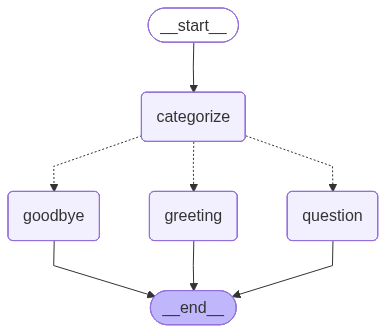

In [40]:
try:
    display(Image(chatbot_app.get_graph().draw_mermaid_png()))
except Exception:
    print(chatbot_app.get_graph().draw_ascii())

---

# Summary

## Key Takeaways

### 1. Graphs
- Execute in **super-steps** (message passing)
- Parallel nodes = same super-step
- Sequential nodes = separate super-steps

### 2. State
- Define with **TypedDict**, **dataclass**, or **Pydantic**
- **Reducers** control how updates are applied
- Default reducer = overwrite
- Use `Annotated[type, reducer]` for custom reducers
- `add_messages` is special for conversation history
- `MessagesState` is a convenient helper

### 3. Nodes
- Just **Python functions**
- Accept `state`, optionally `config` and `runtime`
- Return state updates (not full state)
- Can be sync or async

### 4. Edges
- **Normal edges**: Fixed path (A → B)
- **Conditional edges**: Dynamic routing via router function
- **Command**: Combine state updates + routing
- **START** and **END**: Special entry/exit nodes


## Next Steps

Now that you understand the fundamentals, you're ready for:
- **Streaming**: Real-time output
- **Human-in-the-loop**: Interactive workflows
- **Persistence**: Database-backed state
- **Multi-agent systems**: Complex coordination

Keep building! 🚀

---

# Exercises

Try these exercises to practice:

1. **Custom Reducer**: Create a state with a custom reducer that multiplies numbers
2. **Parallel Execution**: Build a graph with 3 nodes running in parallel
3. **Complex Routing**: Create a router with 4+ different paths
4. **Command Pattern**: Use `Command` to create a loop with a counter
5. **Multi-Schema**: Build a graph with separate input/output schemas

Good luck! 💪